In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import networkx as nx
import seaborn as sns

from spikeometric.models import BernoulliGLM

from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj, to_networkx, from_networkx

from functions import *

ModuleNotFoundError: No module named 'edu'

In [ ]:
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.cit import d_separation, CIT
from causallearn.utils.DAG2PAG import dag2pag
from causallearn.graph.GraphNode import GraphNode
from causallearn.graph.Dag import Dag
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.utils.GraphUtils import GraphUtils

In [31]:
G = nx.DiGraph()
G.add_nodes_from(np.arange(6))
G.add_edges_from([(0, 1), (2, 3), (4, 5), (2, 1), (2, 5)])

pag, _ = fci(np.empty(shape=(10**2, 6)), 
            d_separation, 
            true_dag=G,
            )
nodes = pag.get_nodes()

kn = BackgroundKnowledge()
kn.add_node_to_tier(nodes[0], 0)
kn.add_node_to_tier(nodes[2], 0)
kn.add_node_to_tier(nodes[4], 0)

kn.add_node_to_tier(nodes[1], 1)
kn.add_node_to_tier(nodes[3], 1)
kn.add_node_to_tier(nodes[5], 1)

#kn.add_required_by_node(nodes[0], nodes[1])
#kn.add_required_by_node(nodes[2], nodes[3])
#kn.add_required_by_node(nodes[4], nodes[5])

pag, _ = fci(np.empty(shape=(10**2, 6)), 
            d_separation, 
            true_dag=G,
            background_knowledge=kn,
            )
print(pag)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X3 --> X2
Orienting edge (Knowledge): X3 --> X4
Orienting edge (Knowledge): X3 --> X6
Orienting edge (Knowledge): X5 --> X6
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X3 --> X2
Orienting edge (Knowledge): X3 --> X4
Orienting edge (Knowledge): X3 --> X6
Orienting edge (Knowledge): X5 --> X6
Finishing BK Orientation.
Graph Nodes:
X1;X2;X3;X4;X5;X6

Graph Edges:
1. X1 --> X2
2. X3 --> X2
3. X3 --> X4
4. X3 --> X6
5. X5 --> X6



### C elegans

In [3]:
c_elegans_network = torch.load('data/c_elegans_data.pt')

In [4]:
G_summary = to_networkx(c_elegans_network, node_attrs = ['position'])
n_neurons = G_summary.number_of_nodes()

position_dict = nx.get_node_attributes(G_summary, 'position')
sample_space = []
upper = 0.2 # head
lower = 0.
for neuron in position_dict:
    if position_dict[neuron] >= lower and position_dict[neuron] < upper:
        sample_space.append(neuron)
        
n_obs = 2
index_obs = np.sort(np.random.choice(sample_space, size = n_obs, replace = False))
index_obs = [202, 141, 75, 111, 250, 116, 275, 16, 36, 263, 39, 13, 272]
index_obs = np.sort([202, 141, 250])
#index_obs=np.sort([202, 250, 116])
G_summary_observed = nx.subgraph(G_summary, index_obs)

In [16]:
G_summary_observed = nx.DiGraph()
G_summary_observed.add_nodes_from(np.arange(3))
G_summary_observed.add_edges_from([(1, 0), (1, 2)])
n_timelags = 1
num_nodes = G_summary_observed.number_of_nodes()
G_fulltime, pos, with_time_label = create_fulltime_graph(G_summary_observed, n_timelags=n_timelags)

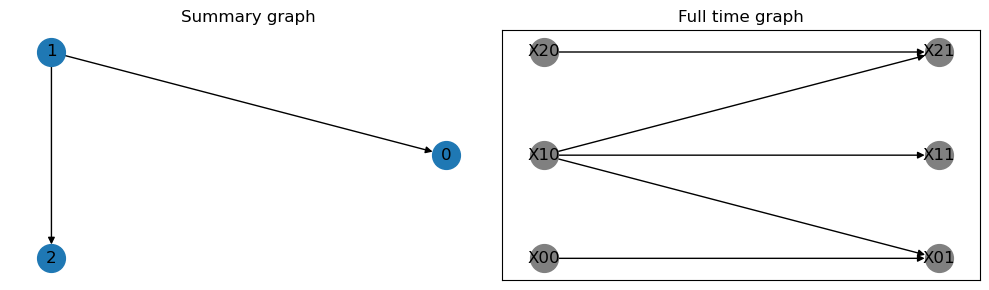

In [17]:
# visualisation of one of the networks generated
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
nx.draw_circular(G_summary_observed, arrows=True, ax=ax[0], with_labels=True, node_size=400, alpha=1)
ax[0].set_title("Summary graph")
nx.draw_networkx(G_fulltime, pos=pos, labels=with_time_label, node_size=400, node_color='grey',ax=ax[1])
ax[1].set_title("Full time graph")
plt.tight_layout()
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X3 --> X2
Orienting edge (Knowledge): X3 --> X4
Orienting edge (Knowledge): X3 --> X6
Orienting edge (Knowledge): X5 --> X6
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X3 --> X2
Orienting edge (Knowledge): X3 --> X4
Orienting edge (Knowledge): X3 --> X6
Orienting edge (Knowledge): X5 --> X6
Finishing BK Orientation.
Graph Nodes:
X1;X2;X3;X4;X5;X6

Graph Edges:
1. X1 --> X2
2. X3 --> X2
3. X3 --> X4
4. X3 --> X6
5. X5 --> X6



In [22]:
# set up the neuron model
neuron_model = BernoulliGLM(
    theta=3.,
    dt=1.,
    coupling_window=2,
    abs_ref_scale=1,
    abs_ref_strength=-100,
    rel_ref_scale=0,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0,
    r = 1
)

sim_time = 10**5
#spikes = neuron_model.simulate(c_elegans_network, n_steps=sim_time)

network = from_networkx(G_summary_observed)
num_edges = G_summary_observed.number_of_edges()
network.W0 = torch.ones(G_summary_observed.number_of_edges())
network.W0[:num_edges//2] = 1.5
network.W0[num_edges//2:] = 1.5
print(network.edge_index)

tensor([[1, 1],
        [0, 2]])


In [8]:
spikes = neuron_model.simulate(network, n_steps=sim_time)

100%|████████████████████████████████| 100000/100000 [00:05<00:00, 17634.96it/s]


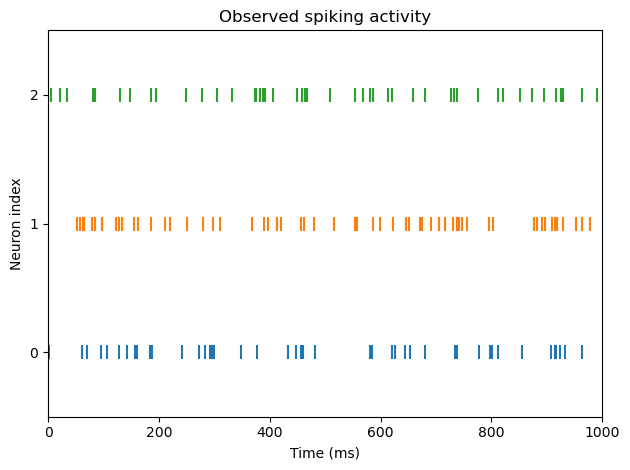

In [9]:
make_rasterplot(spikes)

In [10]:
fulltimegraph_data = np.empty((G_fulltime.number_of_nodes(), sim_time))
for i, node_name in enumerate(G_summary_observed.nodes()):
    node_idx = i*(n_timelags+1)
    for current_time in range(n_timelags+1):
        #print(f'{node_idx+current_time}: X{i}{current_time}')
        fulltimegraph_data[node_idx + current_time] = np.roll(spikes[i], -current_time)

In [11]:
#fulltimegraph_data[[0,1,2,6,7,8]].shape

In [12]:
# learn w/o background knowledge
G_nobk, _ = fci(fulltimegraph_data.T, 'chisq', 0.05)
nodes = G_nobk.get_nodes()

bk = background_knowledge_timeseries(nodes, 
                                     n_timelags, 
                                     forbid_contemporaneous_effects=True, 
                                     forbid_effect_preceeding_cause=True)
G_bk_finitesample, _ = fci(fulltimegraph_data.T, 'chisq', alpha=0.001, background_knowledge=bk)

# learn w/o background knowledge
G_bk_oracle, _ = fci(np.empty(shape=(10**4, G_fulltime.number_of_nodes())), 
                       d_separation, 
                       true_dag=G_fulltime,
                       background_knowledge=bk,
                      )

  0%|          | 0/9 [00:00<?, ?it/s]

X1 --> X2
X8 --> X1
X2 --> X3
X9 --> X8


  0%|          | 0/9 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X1 --> X3
Orienting edge (Knowledge): X1 --> X5
Orienting edge (Knowledge): X1 --> X6
Orienting edge (Knowledge): X1 --> X8
Orienting edge (Knowledge): X1 --> X9
Orienting edge (Knowledge): X2 --> X3
Orienting edge (Knowledge): X2 --> X6
Orienting edge (Knowledge): X2 --> X9
Orienting edge (Knowledge): X4 --> X5
Orienting edge (Knowledge): X4 --> X6
Orienting edge (Knowledge): X5 --> X6
Orienting edge (Knowledge): X7 --> X8
Orienting edge (Knowledge): X7 --> X9
Orienting edge (Knowledge): X8 --> X9
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X1 --> X3
Orienting edge (Knowledge): X1 --> X5
Orienting edge (Knowledge): X1 --> X6
Orienting edge (Knowledge): X1 --> X8
Orienting edge (Knowledge): X1 --> X9
Orienting edge (Knowledge): X2 --> X3
Orienting edge (Knowledge): X2 --> X6
Orienting edge (Knowledge): X2 --> X9
Orienting ed

  0%|          | 0/9 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X1 --> X5
Orienting edge (Knowledge): X1 --> X6
Orienting edge (Knowledge): X1 --> X8
Orienting edge (Knowledge): X1 --> X9
Orienting edge (Knowledge): X2 --> X3
Orienting edge (Knowledge): X2 --> X6
Orienting edge (Knowledge): X2 --> X9
Orienting edge (Knowledge): X4 --> X5
Orienting edge (Knowledge): X5 --> X6
Orienting edge (Knowledge): X7 --> X8
Orienting edge (Knowledge): X8 --> X9
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X1 --> X5
Orienting edge (Knowledge): X1 --> X6
Orienting edge (Knowledge): X1 --> X8
Orienting edge (Knowledge): X1 --> X9
Orienting edge (Knowledge): X2 --> X3
Orienting edge (Knowledge): X2 --> X6
Orienting edge (Knowledge): X2 --> X9
Orienting edge (Knowledge): X4 --> X5
Orienting edge (Knowledge): X5 --> X6
Orienting edge (Knowledge): X7 --> X8
Orienting edge (Knowledge): X8 --> X9
Finishing BK

In [13]:
print(G_bk_oracle)

Graph Nodes:
X1;X2;X3;X4;X5;X6;X7;X8;X9

Graph Edges:
1. X1 --> X2
2. X1 --> X5
3. X1 --> X6
4. X1 --> X8
5. X1 --> X9
6. X2 --> X3
7. X2 --> X6
8. X2 --> X9
9. X4 --> X5
10. X5 --> X6
11. X7 --> X8
12. X8 --> X9



In [25]:
G_fulltime_learned = nx.DiGraph()
G_fulltime_learned.add_nodes_from(G_fulltime.nodes())

#G_learned = G_bk_oracle
G_learned = G_bk_finitesample

edge_color = []

for i, node_name in enumerate(G_summary_observed.nodes()):
    node_idx = i*(n_timelags+1)
    
    for j, target_name in enumerate(G_summary_observed.nodes()):
        target_idx = j*(n_timelags+1)
        
        for current_time in range(n_timelags+1):
            
            for effect_time in range(n_timelags+1):
                
                no_arrowhead_atA = G_learned.graph[node_idx + current_time, target_idx + effect_time] == -1
                arrowhead_atB = G_learned.graph[target_idx + effect_time, node_idx + current_time] == 1
                arrowhead_atA = G_learned.graph[node_idx + current_time, target_idx + effect_time] == 1

                if no_arrowhead_atA and arrowhead_atB:
                    print(f'X{i}{current_time}->X{j}{effect_time}')
                    G_fulltime_learned.add_edge(node_idx+current_time, target_idx+effect_time)
                    edge_color.append('black')
                    
                if arrowhead_atA and arrowhead_atB:
                    G_fulltime_learned.add_edge(node_idx + current_time, target_idx + effect_time)
                    G_fulltime_learned.add_edge(target_idx + effect_time, node_idx + current_time)
                    print(f'X{i}{current_time}<->X{j}{effect_time}')
                    edge_color.append('red')
                    edge_color.append('red')



X00->X01
X10->X11
X20->X21


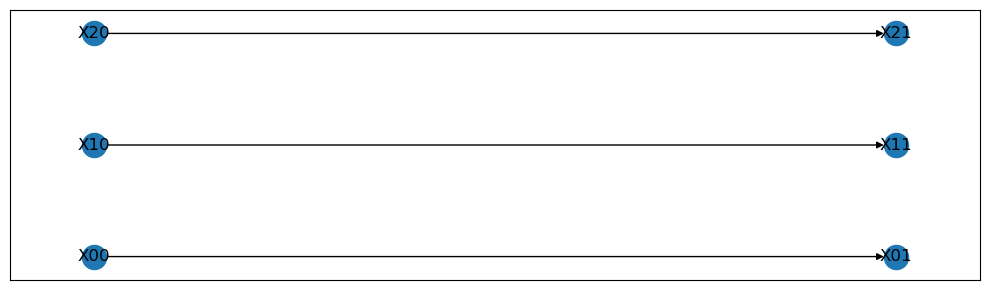

In [26]:
plt.figure(figsize=(10, 3))
nx.draw_networkx(G_fulltime_learned, pos=pos, labels=with_time_label, node_size=300, edge_color='k')
plt.tight_layout()
plt.show()

In [139]:
# learn w/o background knowledge
G_learned, _ = fci(np.empty(shape=(10**4, G_fulltime.number_of_nodes())), 
                       d_separation, 
                       verbose=False, 
                       true_dag=G_fulltime,
                       max_path_length=n_timelags,
                       background_knowledge=bk,
                       show_progress=True            
                      )

  0%|          | 0/8 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X1 --> X8
Orienting edge (Knowledge): X2 --> X3
Orienting edge (Knowledge): X2 --> X8
Orienting edge (Knowledge): X3 --> X4
Orienting edge (Knowledge): X3 --> X8
Orienting edge (Knowledge): X5 --> X6
Orienting edge (Knowledge): X6 --> X7
Orienting edge (Knowledge): X7 --> X8
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X1 --> X8
Orienting edge (Knowledge): X2 --> X3
Orienting edge (Knowledge): X2 --> X8
Orienting edge (Knowledge): X3 --> X4
Orienting edge (Knowledge): X3 --> X8
Orienting edge (Knowledge): X5 --> X6
Orienting edge (Knowledge): X6 --> X7
Orienting edge (Knowledge): X7 --> X8
Finishing BK Orientation.
X2 --> X3
X2 --> X8
X3 --> X4
X3 --> X8
X6 --> X7
X7 --> X8


In [140]:
print(G_learned)

Graph Nodes:
X1;X2;X3;X4;X5;X6;X7;X8

Graph Edges:
1. X1 --> X2
2. X1 o-> X6
3. X1 --> X7
4. X1 --> X8
5. X2 --> X3
6. X2 o-> X7
7. X2 --> X8
8. X3 --> X4
9. X3 --> X8
10. X5 --> X6
11. X6 --> X7
12. X7 --> X8



In [141]:
nodes = G_learned.get_nodes()

In [142]:
len(nodes)

8

In [46]:
# add background knowledge
bk = BackgroundKnowledge()

for i in range(num_nodes):
    node_idx = i*(n_timelags+1)

    for tau in range(n_timelags):
        # History effects are required
        bk.add_required_by_node(nodes[node_idx + tau], nodes[node_idx + tau + 1])
        #print('Require:')
        #print(with_time_label[node_idx + tau], '->', with_time_label[node_idx + tau + 1])
        #continue
           
    # loop through nodes in network
    for j in range(num_nodes):
        target_idx = j*(n_timelags+1)
          
        for tau in range(n_timelags+1):

            if target_idx != node_idx:    
                # No contamporareous effects
                bk.add_forbidden_by_node(nodes[node_idx + tau], nodes[target_idx + tau])  
                #print('Forbidden (simultaneous edges):')
                #print(with_time_label[node_idx + tau],'->', with_time_label[target_idx + tau])
                #continue

            for shift in range(1, tau+1):
                    # Not allowed going back in time
                    bk.add_forbidden_by_node(nodes[node_idx+tau], nodes[target_idx + tau - shift])
                    #print('Forbidden (reverse time edges):')
                    #print(with_time_label[node_idx + tau], '->', with_time_label[target_idx + tau - shift])

In [47]:
with_time_label
n_timelags
num_nodes // (n_timelags+1)

0

In [48]:
# learn with background knowledge
G_learned, _ = fci(np.empty(shape=(10**4, G_fulltime.number_of_nodes())), 
                       d_separation, 0.01, 
                       verbose=False, 
                       true_dag=G_fulltime,
                       background_knowledge=bk,
                       max_path_length=n_timelags
                      )

  0%|          | 0/8 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X1 --> X6
Orienting edge (Knowledge): X1 --> X7
Orienting edge (Knowledge): X1 --> X8
Orienting edge (Knowledge): X2 --> X3
Orienting edge (Knowledge): X2 --> X7
Orienting edge (Knowledge): X2 --> X8
Orienting edge (Knowledge): X3 --> X4
Orienting edge (Knowledge): X3 --> X8
Orienting edge (Knowledge): X5 --> X6
Orienting edge (Knowledge): X6 --> X7
Orienting edge (Knowledge): X7 --> X8
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X2
Orienting edge (Knowledge): X1 --> X6
Orienting edge (Knowledge): X1 --> X7
Orienting edge (Knowledge): X1 --> X8
Orienting edge (Knowledge): X2 --> X3
Orienting edge (Knowledge): X2 --> X7
Orienting edge (Knowledge): X2 --> X8
Orienting edge (Knowledge): X3 --> X4
Orienting edge (Knowledge): X3 --> X8
Orienting edge (Knowledge): X5 --> X6
Orienting edge (Knowledge): X6 --> X7
Orienting edge (Knowledge): X7 --> X8
Finishing BK

In [49]:
print(G_learned)

Graph Nodes:
X1;X2;X3;X4;X5;X6;X7;X8

Graph Edges:
1. X1 --> X2
2. X1 --> X6
3. X1 --> X7
4. X1 --> X8
5. X2 --> X3
6. X2 --> X7
7. X2 --> X8
8. X3 --> X4
9. X3 --> X8
10. X5 --> X6
11. X6 --> X7
12. X7 --> X8



In [143]:
ground_truth_edges = []

for u, v in G_fulltime.edges():
    ground_truth_edges.append((nodes[u], nodes[v]))
    #print(with_time_label[u], '->', with_time_label[v])

ground_truth_dag = Dag(nodes)

for edge in ground_truth_edges:
    u, v = edge
    ground_truth_dag.add_directed_edge(u, v)

#pag = dag2pag(ground_truth_dag, [])
print(ground_truth_dag.graph)

Graph Nodes:
X1;X2;X3;X4;X5;X6;X7;X8

Graph Edges:
1. X1 --> X2
2. X1 --> X6
3. X1 --> X7
4. X1 --> X8
5. X2 --> X3
6. X2 --> X7
7. X2 --> X8
8. X3 --> X4
9. X3 --> X8
10. X5 --> X6
11. X6 --> X7
12. X7 --> X8



In [153]:
pd = GraphUtils.to_pydot(ground_truth_dag)

In [154]:
pd.write_png('test.png')

FileNotFoundError: [Errno 2] "dot" not found in path.

## Alternative testing approaches:
- Transfer entropy
- Partial correlation

In [336]:
idx2nodename

{0: 202, 1: 250, 2: 141}

In [354]:
pag = dag2pag(ground_truth_dag, islatent=[nodes[0], nodes[1], nodes[2]])

In [355]:
print(pag)

Graph Nodes:
X5;X4;X8;X9;X7;X6

Graph Edges:
1. X4 o-> X5
2. X5 <-> X8
3. X5 <-> X9
4. X5 o-o X6
5. X4 o-> X6
6. X8 o-o X9
7. X7 o-> X8
8. X8 <-> X6
9. X7 o-> X9
10. X9 <-> X6



### Notater
- Kan bruke FCI med bakgrunnskunnskap på simulerte data og lære en graf som kan indikere latente variabler
- Må implementere: en måte å evaluere resultatet fra FCI
- Når jeg har kort refraktær og kobling (1 tidsenhet) så funker finite sample OK for et helt enkelt system med 2 celler og eksitatorisk kobling
- burde kanskje anvende fci på ett nettverk med endelig antall datapunkter og se hvor konsistent resultatene er, se hvordan de avhenger av størrelsen på datasettet, og sammenligne ulike CI test metoder